In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# Read data and cast
train = pd.read_csv('train_cleaned.csv', dtype={'fullVisitorId': 'str'})
test = pd.read_csv('test_cleaned.csv', dtype={'fullVisitorId': 'str'})

train.loc[:,'visitStartTime'] = pd.to_datetime(train.loc[:,'visitStartTime'])
test.loc[:,'visitStartTime'] = pd.to_datetime(test.loc[:,'visitStartTime'])

train.loc[:,'date'] = pd.to_datetime(train.loc[:,'date'])
test.loc[:,'date'] = pd.to_datetime(test.loc[:,'date'])


In [3]:
# Use metro+city as identifier of location
train['metro-city'] = train['geoNetwork.metro'] + '-' + train['geoNetwork.city']
test['metro-city'] = test['geoNetwork.metro'] + '-' + test['geoNetwork.city']

# Combine source and medium as one feature
train['source-medium'] = train['trafficSource.source'] + '-' + train['trafficSource.medium']
test['source-medium'] = test['trafficSource.source'] + '-' + test['trafficSource.medium']

In [4]:
total = pd.concat([train, test], axis=0, sort=False)

In [5]:
# Recode categorical levels without revenue to one level as 'noRev'

# Variables with large number of unique values
cats = ['channelGrouping','device.browser', 'device.operatingSystem',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.page', 'trafficSource.campaign', 'trafficSource.keyword',
       'trafficSource.referralPath',
       'metro-city', 'source-medium']

# Return corresponding average revenue of each value in a variable
def cat_sess_rev(colname):
    df = train[[colname, 'totals.transactionRevenue']].groupby([colname]).mean().reset_index()
    df.columns = [colname, 'mean_revenue']
    df = df.sort_values(by='mean_revenue', ascending=False)
    return df

# Get a set of values in a variable that generate revenue
def non_zero_rev(colname):
    df = cat_sess_rev(colname)
    with_rev = set(df[df['mean_revenue']>0][colname])
    return with_rev

# Recode values that don't have revenue
def recode_zero_rev(val, with_rev):
    if val not in with_rev:
        return 'noRev'
    else:
        return val
# Recode each categorical variables
for i in cats:
    with_rev_set = non_zero_rev(i)
    total.loc[:,i] = total[i].apply(lambda x: recode_zero_rev(x, with_rev_set))
    print(i+' recoding complete')

channelGrouping recoding complete
device.browser recoding complete
device.operatingSystem recoding complete
trafficSource.adContent recoding complete
trafficSource.adwordsClickInfo.page recoding complete
trafficSource.campaign recoding complete
trafficSource.keyword recoding complete
trafficSource.referralPath recoding complete
metro-city recoding complete
source-medium recoding complete


In [6]:
# Drop some variables
total = total.drop(['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'trafficSource.source', 'trafficSource.medium'], axis=1)

In [7]:
# Create some more features based on time
# Day of week of visit
total['dayofweek'] = (pd.DatetimeIndex(total['date']).dayofweek).astype(str)

# The number of days from the earliest date in the data
total['days_from_first'] = ((total['date'] - total['date'].min()) / np.timedelta64(1, 'D')).astype(int)

# The time of day of visit (Note: need to be localized based on timezone)
total['visitStartHour'] = total['visitStartTime'].apply(lambda x: x.hour).astype(str)

# The month of visit
total['visitMonth'] = total['date'].apply(lambda x: x.month).astype(str)


In [8]:
# Function for creating cumulative sum feature
def cum_sum(data, colname, add):
    sub_sorted = total[['fullVisitorId', colname, 'visitStartTime']].sort_values(by='visitStartTime')
    ex = sub_sorted.groupby(by=['fullVisitorId', 'visitStartTime']).sum().groupby(level=[0]).cumsum().reset_index()
    ex.columns = ['fullVisitorId', 'visitStartTime', 'cumSum_'+add]
    return pd.merge(data, ex, on=['fullVisitorId', 'visitStartTime'], how='left')

In [9]:
# Create a feature of cumulative sum of revenue for this user before this visit
total = cum_sum(total, 'totals.transactionRevenue', 'rev')

total['cumSum_rev'] = total['cumSum_rev'] - total['totals.transactionRevenue']


In [12]:
# Split train/test
train_Xy = total.iloc[0:903653,:]
test_X = total.iloc[903653:1708337,:].drop(['totals.transactionRevenue'], axis=1)

In [13]:
# Mean-encoding with K-fold on train
from sklearn.model_selection import KFold
kf = KFold(20, shuffle=True, random_state=220)

to_encode = ['channelGrouping','device.browser', 'device.operatingSystem',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.page', 
             'trafficSource.campaign', 'trafficSource.keyword', 
             'trafficSource.referralPath', 'metro-city', 'dayofweek', 
             'visitStartHour', 'visitMonth','source-medium']
start_in = train_Xy.shape[1]
col_in = train_Xy.shape[1]

for name in to_encode:
    train_Xy[name+'_enc'] = 1704272.8126836296
    for tr_ind, val_ind in kf.split(train_Xy):
        X_tr, X_val = train_Xy.iloc[tr_ind], train_Xy.iloc[val_ind]
        mean = X_val[name].map(X_tr.groupby(name)['totals.transactionRevenue'].mean())
        train_Xy.iloc[val_ind, col_in] = mean
    col_in += 1

train_Xy.iloc[:, start_in:] = train_Xy.iloc[:, start_in:].fillna(1704272.8126836296)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
# Mean-encoding on test
col_in = test_X.shape[1]
for name in to_encode:
    test_X[name+'_enc'] = 1704272.8126836296
    mean = test_X[name].map(train_Xy.groupby(name)['totals.transactionRevenue'].mean())
    test_X.iloc[:, col_in] = mean
    col_in += 1

In [15]:
# Drop encoded feature and others
to_drop = ['fullVisitorId', 'trafficSource.adwordsClickInfo.gclId', 'date', 'sessionId', 'visitId', 'visitStartTime']
train_Xy = train_Xy.drop(to_encode, axis=1)
test_X = test_X.drop(to_encode, axis=1)

train_Xy = train_Xy.drop(to_drop, axis=1)
test_X = test_X.drop(to_drop, axis=1)

In [16]:
# Define X and Y
y = train_Xy['totals.transactionRevenue']
train_X = train_Xy.drop('totals.transactionRevenue', axis=1)
y = np.log1p(y) # Important!

In [17]:
# One-hot encoding on categorical features with not many levels
train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_X)
# Drop cols from test that not exist in train
test_X = test_X.drop(['trafficSource.adwordsClickInfo.adNetworkType_Content',
                      'trafficSource.adwordsClickInfo.slot_Google Display Network'], axis=1)


In [18]:
# Start modeling!
import lightgbm as lgb

In [19]:
params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 5,
        "bagging_seed" : 220,
        "verbosity" : -1
    }

In [20]:
lgb_train = lgb.Dataset(train_X, y)
gbm_1 = lgb.train(params,
                lgb_train
                )

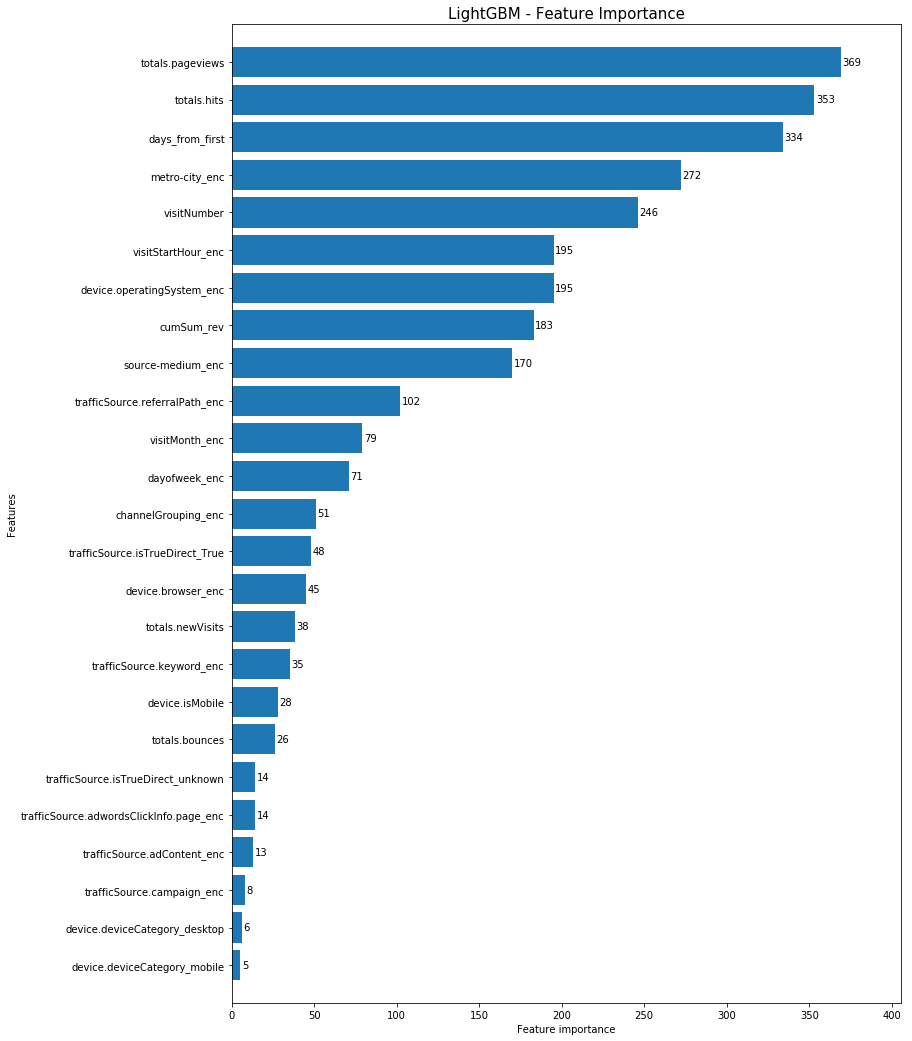

In [21]:
# Show feature importances
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(gbm_1, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()


In [22]:
# Predic on test
pred1 = gbm_1.predict(test_X)

In [23]:
sub_sample = pd.read_csv('sample_submission.csv')

# Function for making and exporting submission
def make_sub(pred, filename):
    pred_df = pd.DataFrame({'fullVisitorId': test['fullVisitorId'], 
                        'rev': np.expm1(pred)})
    pred_df['rev'].loc[pred_df['rev']<0] = 0
    sub = pred_df.groupby('fullVisitorId')['rev'].sum().reset_index()
    sub.columns = ['fullVisitorId', 'y']
    sub['target'] = np.log1p(sub['y'])
    sub = sub.drop(['y'], axis=1)
    sub_sample_new = sub_sample.merge(sub)
    sub_sample_new['PredictedLogRevenue'] = sub_sample_new['target']
    sub_sample_new = sub_sample_new.drop('target', axis=1)
    sub_sample_new.to_csv(filename, index=False)
    return sub_sample_new

In [24]:
# Make a subimission
make_sub(pred1,'new_sub_addcum.csv')

/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.685981
1,0000049363351866189,0.002810
2,0000053049821714864,0.000000
3,0000059488412965267,0.000000
4,0000085840370633780,0.017393
5,0000091131414287111,0.000000
6,0000117255350596610,4.739398
7,0000118334805178127,0.000000
8,0000130646294093000,0.000000
9,0000150005271820273,0.001518


In [25]:
train_vid = train['fullVisitorId']
test_vid = test['fullVisitorId']
from sklearn.metrics import mean_squared_error

def lgb_val(para, train_ind, val_ind):
    lgb_train = lgb.Dataset(train_X.iloc[train_ind], y.iloc[train_ind])
    model = lgb.train(para, lgb_train)
    pred = model.predict(train_X.iloc[val_ind])
    df = pd.DataFrame({'fullVisitorId': train_vid.loc[val_ind],
                       'pred': np.expm1(pred),
                      'real': np.expm1(y.iloc[val_ind])})
    df['pred'].loc[df['pred']<0] = 0
    
    target_pred = df.groupby('fullVisitorId')['pred'].sum().reset_index().iloc[:,1]
    target_pred = np.log1p(target_pred)
    target_real = df.groupby('fullVisitorId')['real'].sum().reset_index().iloc[:,1]
    target_real = np.log1p(target_real)
    
    return target_pred, target_real, np.sqrt(mean_squared_error(target_real, target_pred))

In [26]:
# Train on part of the training set and validate on the rest, get the RMSE
re_all = lgb_val(params, range(0, 800000), range(800000, 903653))
print(re_all[2])

/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1.6655473553479128


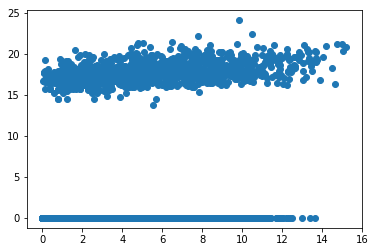

In [27]:
# Plot predicted value and real value
plt.scatter(re_all[0], re_all[1])